In [1]:
#Imports
import numpy as np
import pandas as pd
import pylab as pb
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf as acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.tsa.api as smt
from scipy.optimize import leastsq
from scipy.stats import norm

C:\Users\Loosc\Anaconda3\envs\mladv\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Read data as panda.DataFrame
pdData = pd.read_csv('data/Mauna_Loa_CO2_monthly_mean_data.csv',
                     sep=',',header=None);
pdDataYearly = pd.read_csv('data/Mauna_Loa_CO2_yearly_mean_data.csv',
                           sep='   ',header=0,engine='python');

removeYears = 0;

#clean Data, remove first and last year.
pdData.drop(pdData.index[[718,719,720]],inplace=True)
pdData.drop(pdData.index[np.arange(10 + removeYears*12)],inplace=True)
pdDataYearly.drop(pdDataYearly.index[np.arange(removeYears)],inplace=True)

#Also save as numpy array
npData = pdData.as_matrix();
npDataYearly = pdDataYearly.as_matrix();

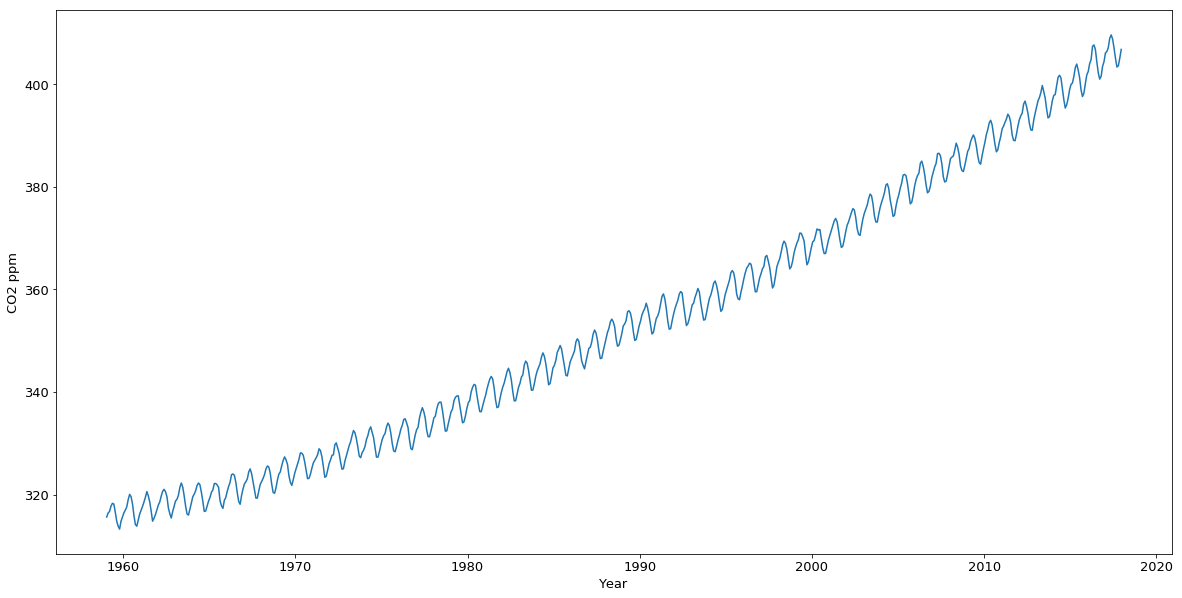

In [17]:
fig, ax = pb.subplots(1,1,figsize=(20,10))
pdData.plot(x=2,y=4,ax=ax,legend="")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 ppm")
#pb.savefig("Data.png")
pb.show()


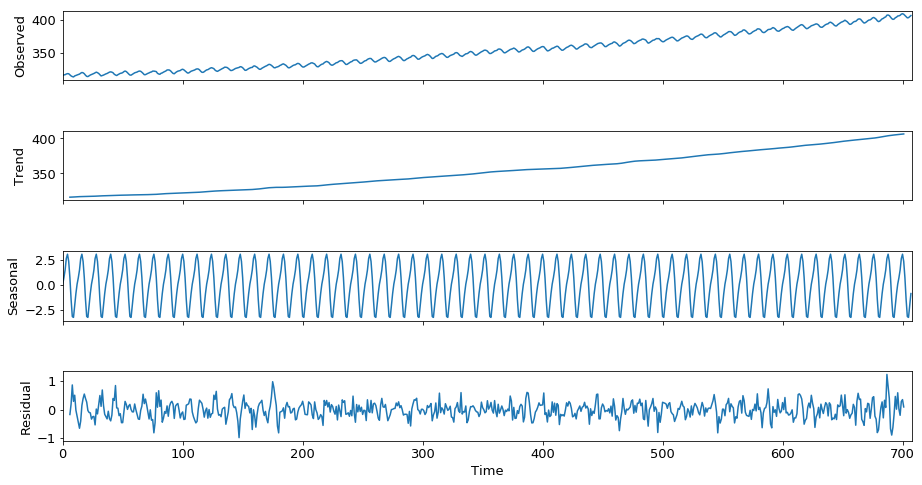

In [18]:
#Create a trend, seasonal decomposition and residual using statsmodels
pb.rcParams.update({'font.size': 13})
decomp = smt.seasonal_decompose(pdData[4].as_matrix(),freq=12);

fig = decomp.plot()  
fig.set_size_inches(15, 8)
pb.savefig("seasonal_decompose.png")
pb.show()

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid



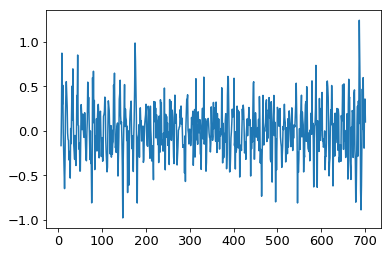

In [5]:
pb.plot(residual)
pb.show()

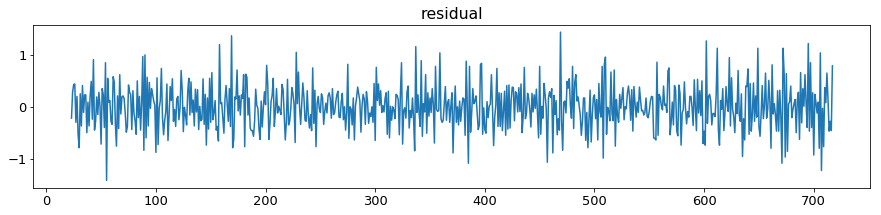

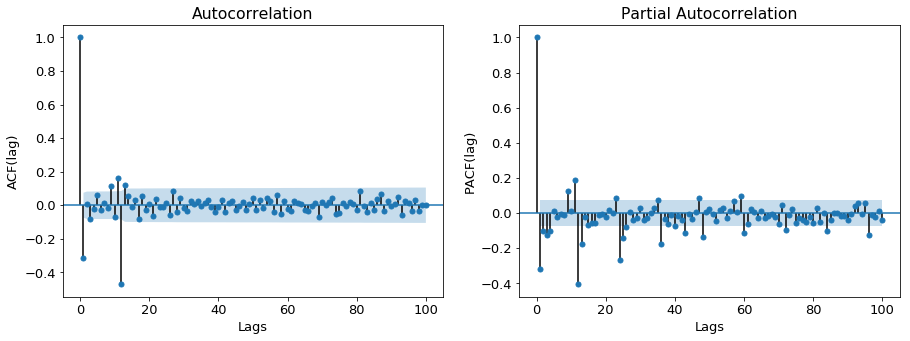


These plots show that we could use an ARIMA with (p,d,q)x(P,D,Q)s = (4,1,1)x(1,1,1)12
Values for p could vary between 1-4, values for q between 1-3. P,D and Q not so sure.


In [19]:
differenciated_data = pdData[4].diff(12).diff(1)
pb.figure(figsize=(15,3))
pb.plot(differenciated_data)



pb.title("residual")
pb.show()
fig, ax = pb.subplots(1,2,figsize=(15,5))
plot_acf(differenciated_data[14:],ax=ax[0],lags=100,label="d=1, s=12")
plot_pacf(differenciated_data[14:],ax=ax[1],lags=100)
ax[0].set_xlabel("Lags")
ax[1].set_xlabel("Lags")
ax[0].set_ylabel("ACF(lag)")
ax[1].set_ylabel("PACF(lag)")
pb.savefig("acf_pacf_1_12.png")
pb.show()

print("\nThese plots show that we could use an ARIMA with (p,d,q)x(P,D,Q)s = (4,1,1)x(1,1,1)12"
     "\nValues for p could vary between 1-4, values for q between 1-3. P,D and Q not so sure.")

In [ ]:
#Gridsearch using aic valyue. Best model found: (1,2,1)x(1,1,2)12
import warnings
warnings.filterwarnings('ignore')

p = [0,1,2,3,4];
d = [0,1]
q = [0,1,2,3,4];
P = [1,2]
Q = [1,2]
D = [1,2]

for i in p:
    for j in d:
        for k in q:
            for l in P:
                for m in D:
                    for n in Q:
                        mod = smt.statespace.SARIMAX(pdData[4].as_matrix(),
                                                     order=(i,j,k), seasonal_order=(l,m,n,12),
                                                     enforce_stationarity=False,
                                                     enforce_invertibility=False)
                        results = mod.fit()
                        print("({},{},{})x({},{},{})12: ".format(i,j,k,l,m,n) + repr(results.aic))

In [7]:
#Fit the model
mod = smt.statespace.SARIMAX(pdData[4].as_matrix(),
                             order=(1,2,2), seasonal_order=(1,1,2,12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
results = mod.fit()
print(results.aic)

332.754963409


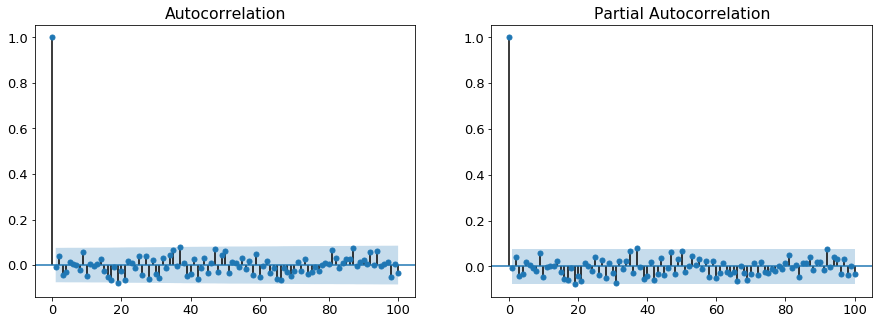

C:\Users\Loosc\Anaconda3\envs\mladv\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


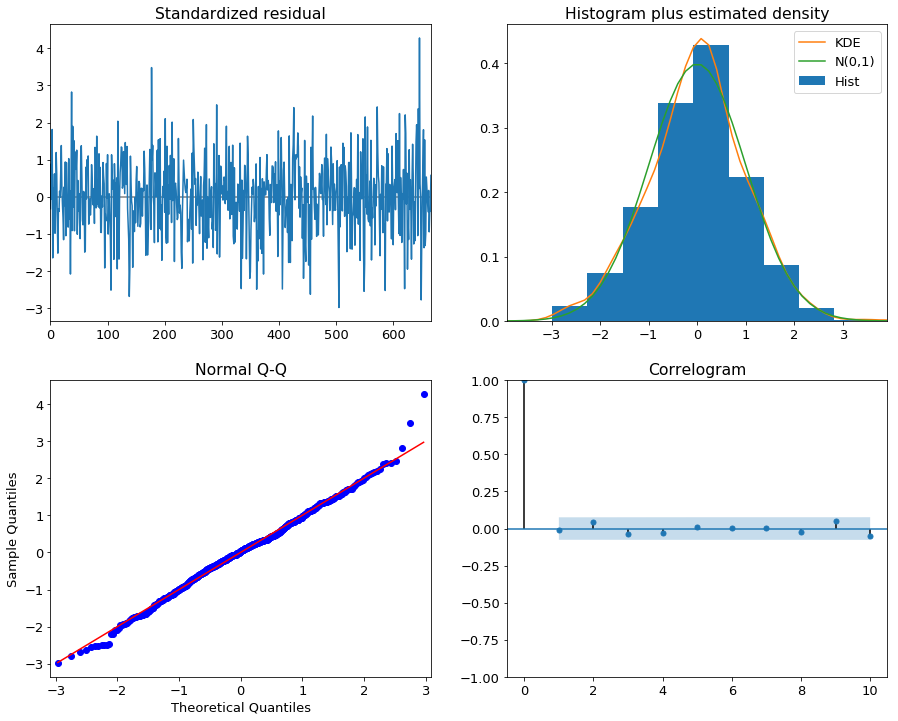



Dickey-Fuller p-value: 1.041180083353676e-29


In [29]:
pb.close()
#Plot stuff to see if we got a good fit
fig, ax = pb.subplots(1,2,figsize=(15,5))
plot_acf(results.resid[35:],lags=100,ax=ax[0])
plot_pacf(results.resid[35:],lags=100,ax=ax[1])
#pb.savefig("acf_pacf_resid_after_modelfit.png")
pb.show()
f = results.plot_diagnostics(figsize=(15, 12))
#pb.savefig("model_diagnostics.png")
pb.show()





print("\n\nDickey-Fuller p-value: " + repr(adfuller(results.resid)[1]))

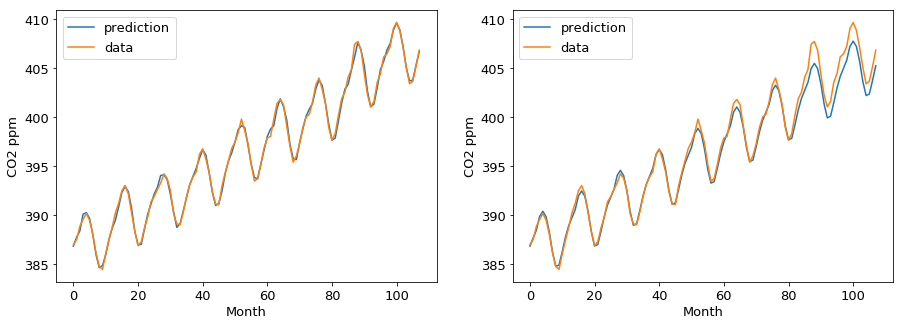

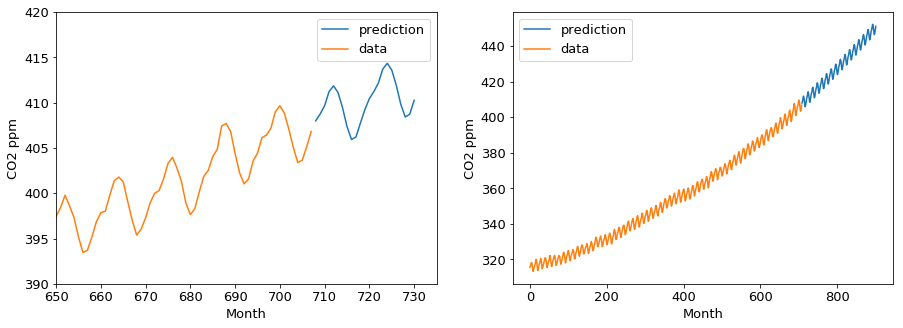

In [31]:
pb.close()
pred1 = results.get_prediction(start = 600, end= 707,dynamic=False) 
pred2 = results.get_prediction(start = 600, end= 707,dynamic=True) 
fig, ax  = pb.subplots(1,2,figsize=(15,5))
ax[0].plot(pred1.predicted_mean,label="prediction")
ax[0].plot(pdData[4].as_matrix()[600:],label="data")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("CO2 ppm")
#ax[0].set_title("Forecasting 1 ahead at a time, using known data.")
ax[0].legend()
ax[1].plot(pred2.predicted_mean,label="prediction")
ax[1].plot(pdData[4].as_matrix()[600:],label="data")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("CO2 ppm")
#ax[1].set_title("Forecasting 1 ahead at a time, using predicted data.")
ax[1].legend()
#pb.savefig("forecasting_known_data.png")
pb.show()

pred3 = results.get_prediction(start = 708, end= 730,dynamic=True)
pred4 = results.get_prediction(start = 708, end= 900,dynamic=True)
fig, ax = pb.subplots(1,2,figsize=(15,5))
ax[0].plot(np.arange(708,731),pred3.predicted_mean,label="prediction")
ax[0].plot(pdData[4].as_matrix(),label="data")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("CO2 ppm")
#ax[0].set_title("Forecasting 1 ahead at a time, using predicted data.")
ax[0].legend()
ax[0].set_xlim(650,735)
ax[0].set_ylim(390,420)
ax[1].set_xlabel("Month")
ax[1].set_ylabel("CO2 ppm")
ax[1].plot(np.arange(708,901),pred4.predicted_mean,label="prediction")
ax[1].plot(pdData[4].as_matrix(),label="data")
#ax[1].set_title("Forecasting 1 ahead at a time, using predicted data.")
ax[1].legend()
#pb.savefig("forecasting_future.png")
pb.show()